## Solving your own MaxCut problem



In [7]:
# All imports
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib

from qiskit_ibm_runtime import SamplerV2 as Sampler

from typing import Sequence

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import os

### Throwback to previous lecture

We saw in a previous lecture an example for MaxCut but we did not go too much into detail.
Today we want to take a closer look, especially to the mapping part,
since mapping is the hardest part and one part which needs a certain understanding of the problem and Quantum Computing,
since it needs to be adapted to each problem specifically.



<a id="step1"></a>
<div class="alert alert-block alert-success">

**Task 1: Understanding the Mapping** What exactly does the below created graph represent? Why would one choose this example for a graph for Max Cut?

> The idea here is to try to understand the mapping part the MaxCut, since in practice this will be the part, which needs to be done specific for each problem.


</div> 

In [ ]:
answer_task_1= """The created graph represents the coupling map of the chosen IBM Quantum device (in this case, ibm_strasbourg). 
A coupling map shows which qubits on the quantum processor are physically connected and can interact directly via 2-qubit gates (like CNOT).
Each edge in the graph indicates a possible direct interaction between two qubits — meaning a 2-qubit gate can be applied between them 
without needing SWAP gates. This is useful for quantum algorithms like MaxCut, where minimizing overhead and circuit depth is critical.

By using the coupling map as the input graph, we ensure that the MaxCut algorithm only uses qubit connections that already exist on the 
hardware, making the execution more efficient.""""

C:\Users\dosqas\AppData\Local\Temp\ipykernel_19452\3737621322.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel='ibm_quantum')


<IBMBackend('ibm_strasbourg')>


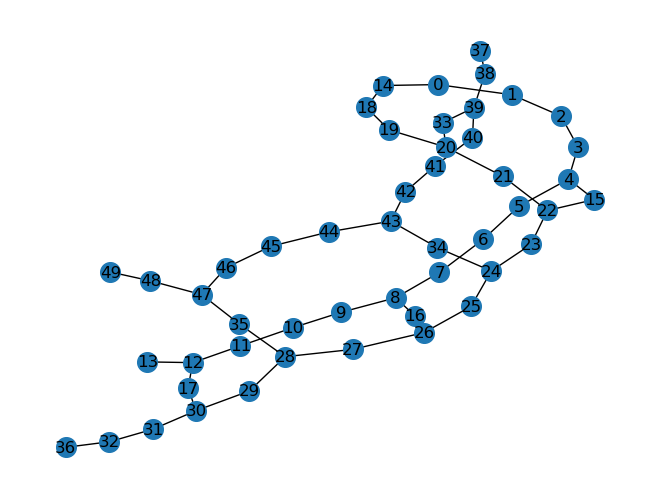

In [13]:
token = os.environ["IBM_QUANTUM_TOKEN"]
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

n = 50  # Number of nodes in graph
graph_50 = rx.PyGraph()
graph_50.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_50.add_edges_from(elist)
draw_graph(graph_50, node_size=200, with_labels=True, width=1)

### Step 0. Find an problem we can solve with Max Cut

We still use MaxCut as an example for optimization, however, we want to solve a different base problem this time, 
by mapping it unto the Max Cut problem. 


Mapping a specific problem A onto a different one B allows us to use the algorithm of problem B also for problem A,
this is important in Quantum Computing since the number of known algorithm is compared to classical computing still small.


The problem at hand is the following:

For complex graphs it is not easy to find a graph colouring: https://en.wikipedia.org/wiki/Graph_coloring 

The basic idea is that you colour vertices in a graph in a way, such that no 2 connected vertices have the same colours and you want to use the least amount of different colours as possible. 


Graph colouring is a graph problem which has applications in schedulings. (Think about planning the crew for a large airline). 


This problem can't be directly solved with Max-Cut, but we can use Max-Cut to tell us directly if a graph can be coloured by only 2 colours. 




<a id="step2"></a>
<div class="alert alert-block alert-success">

**Task 2: Understanding Cutting** What will the result be of MaxCut if the graph can be coloured with just 2 colours?

> Hint: The result of the cut has 2 colours, how are they distributed ideally?


</div> 


In [ ]:
answer_task_2 = """If the graph can be colored with just 2 colours, it means the graph is bipartite.
In a bipartite graph, all edges connect nodes of different colours (i.e., different groups).
Therefore, a MaxCut will cut every edge, since each edge spans the two different groups.
If an edge is not cut, it would mean both its nodes are in the same group (same colour), 
which contradicts the definition of a bipartite graph. Thus, the MaxCut will include all edges."""

#### Step 0-2 create a mapping to a graph.

We want to teach in this exercise how one can in practice map different problems to graphs.

So here we want to map a quantum circuit, which constructs a specific quantum state to a graph. And then answer the question "is this 2-colourable" for this graph by solving Max-Cut.

We use an ideal circuit constructing a GHZ state, because this state has many uses and we know that it maps well to our hardware. 

Below we have the ideal connections for a real quantum device in order to make a GHZ state as efficiently as possible (without using ancilla qubits). 

The GHZ state is created by first doing a Hadamard Gate on qubit 1 and then from there on entangle the other qubits. The entangling gates used can be seen as connections on a graph. 

Create a graph which represents these connections. The lists given are representing the source and target qubit for all entangling gates used.

This code comes from the Spring Challenge 2024 where the GHZ state was used in order to encode data: https://github.com/qiskit-community/ibm-quantum-challenge-2024/blob/main/solutions/lab_bonus/bonus-lab-solutions.ipynb


You dont need to understand the linked lab. Just use the two lists of nodes below to construct your own graph.




In [31]:
# Source of the entangling gates
source_list = [1 , 1 , 2 , 2 , 3 , 3 , 4 , 5 ,  6,  7,  8,  9, 10,  8,  9, 10, 11, 12, 13, 14, 11, 15, 16, 17, 18, 19, 20, 21, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 39, 40, 31, 33, 34, 35, 36, 37, 23, 25, 26]
# target of the entangling gates
target_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]

# premade physical layout mapping the logical qubits (1-52) to physical qubits on a device.
premade_layout = [63, 64, 62, 65, 54, 61, 72, 66, 45, 60, 81, 73, 46, 53, 67, 44, 59, 80, 85, 47, 41, 82, 68, 43, 58, 79, 86, 35, 40, 84, 48, 42, 83, 69, 34, 71, 91, 87, 28, 39, 93, 29, 33, 49, 92, 70, 24, 77, 98, 55, 57, 78]

(0, 1, 1.0)
(0, 2, 1.0)
(1, 3, 1.0)
(1, 4, 1.0)
(2, 5, 1.0)
(2, 6, 1.0)
(3, 7, 1.0)
(4, 8, 1.0)
(5, 9, 1.0)
(6, 10, 1.0)
(7, 11, 1.0)
(8, 12, 1.0)
(9, 13, 1.0)
(7, 14, 1.0)
(8, 15, 1.0)
(9, 16, 1.0)
(10, 17, 1.0)
(11, 18, 1.0)
(12, 19, 1.0)
(13, 20, 1.0)
(10, 21, 1.0)
(14, 22, 1.0)
(15, 23, 1.0)
(16, 24, 1.0)
(17, 25, 1.0)
(18, 26, 1.0)
(19, 27, 1.0)
(20, 28, 1.0)
(18, 29, 1.0)
(19, 30, 1.0)
(20, 31, 1.0)
(21, 32, 1.0)
(22, 33, 1.0)
(23, 34, 1.0)
(24, 35, 1.0)
(25, 36, 1.0)
(26, 37, 1.0)
(27, 38, 1.0)
(28, 39, 1.0)
(37, 40, 1.0)
(38, 41, 1.0)
(39, 42, 1.0)
(30, 43, 1.0)
(32, 44, 1.0)
(33, 45, 1.0)
(34, 46, 1.0)
(35, 47, 1.0)
(36, 48, 1.0)
(22, 49, 1.0)
(24, 50, 1.0)
(25, 51, 1.0)


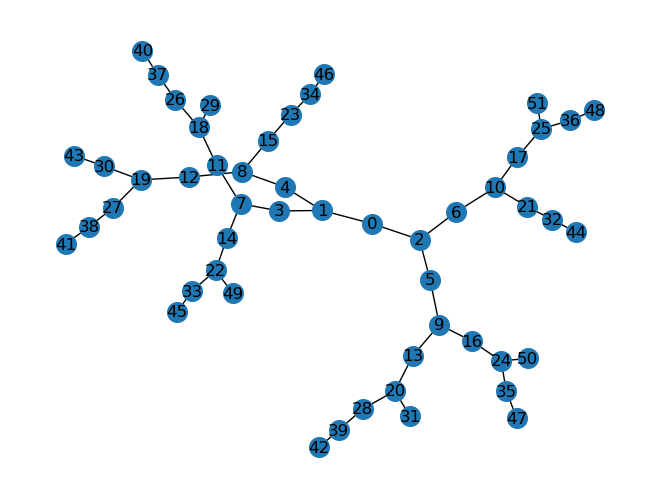

In [33]:
# How many nodes does the graph have?
n = 52

prepared_graph = rx.PyGraph()
prepared_graph.add_nodes_from(np.arange(0, n, 1))
elist = []

#  We iterate here through the number of edges needed. Remember each edge represents 1 entangling gate.
num_steps = 51

for i in range(num_steps):
    node1 = source_list[i] - 1
    node2 = target_list[i] - 1
    elist.append((node1, node2, 1.0))
    print((node1, node2, 1.0))

prepared_graph.add_edges_from(elist)
draw_graph(prepared_graph, node_size=200, with_labels=True, width=1)


<a id="step3"></a>
<div class="alert alert-block alert-success">

**Task 3: Compare Graphs** Add in the above code block all missing code. And then execute it and draw the graph.


</div> 


### Step 1. Map classical inputs to a quantum problem


After we have mapped the classical problem to a graph we now want to map the graph to a Quantum problem.

This part is thanks to the helper functions not too hard, however, we want that you understand how the observables are constructed.

#### Graph → Hamiltonian

First, we convert the graph you want to solve directly into a Hamiltonian that is suited for QAOA.

This can be done automatically with the function below.

In [35]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

In [37]:
max_cut_graph = build_max_cut_paulis(prepared_graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_graph)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIII', 'IIIII

We see the solution, however, we also should understand what is happening here. 


What we can see are different observables which are created, one per edge in the graph. 

The observables are -1 if a node in an edge is between nodes of the two different groups. 

So by minimizing the hamiltonian we maximize the number of edges between different groups and with this the cut. 


<a id="step4"></a>
<div class="alert alert-block alert-success">

**Task 4: Building Observables** Create (by hand) the observables for the graph in the image below (you can leave the coefficients away).


</div> 


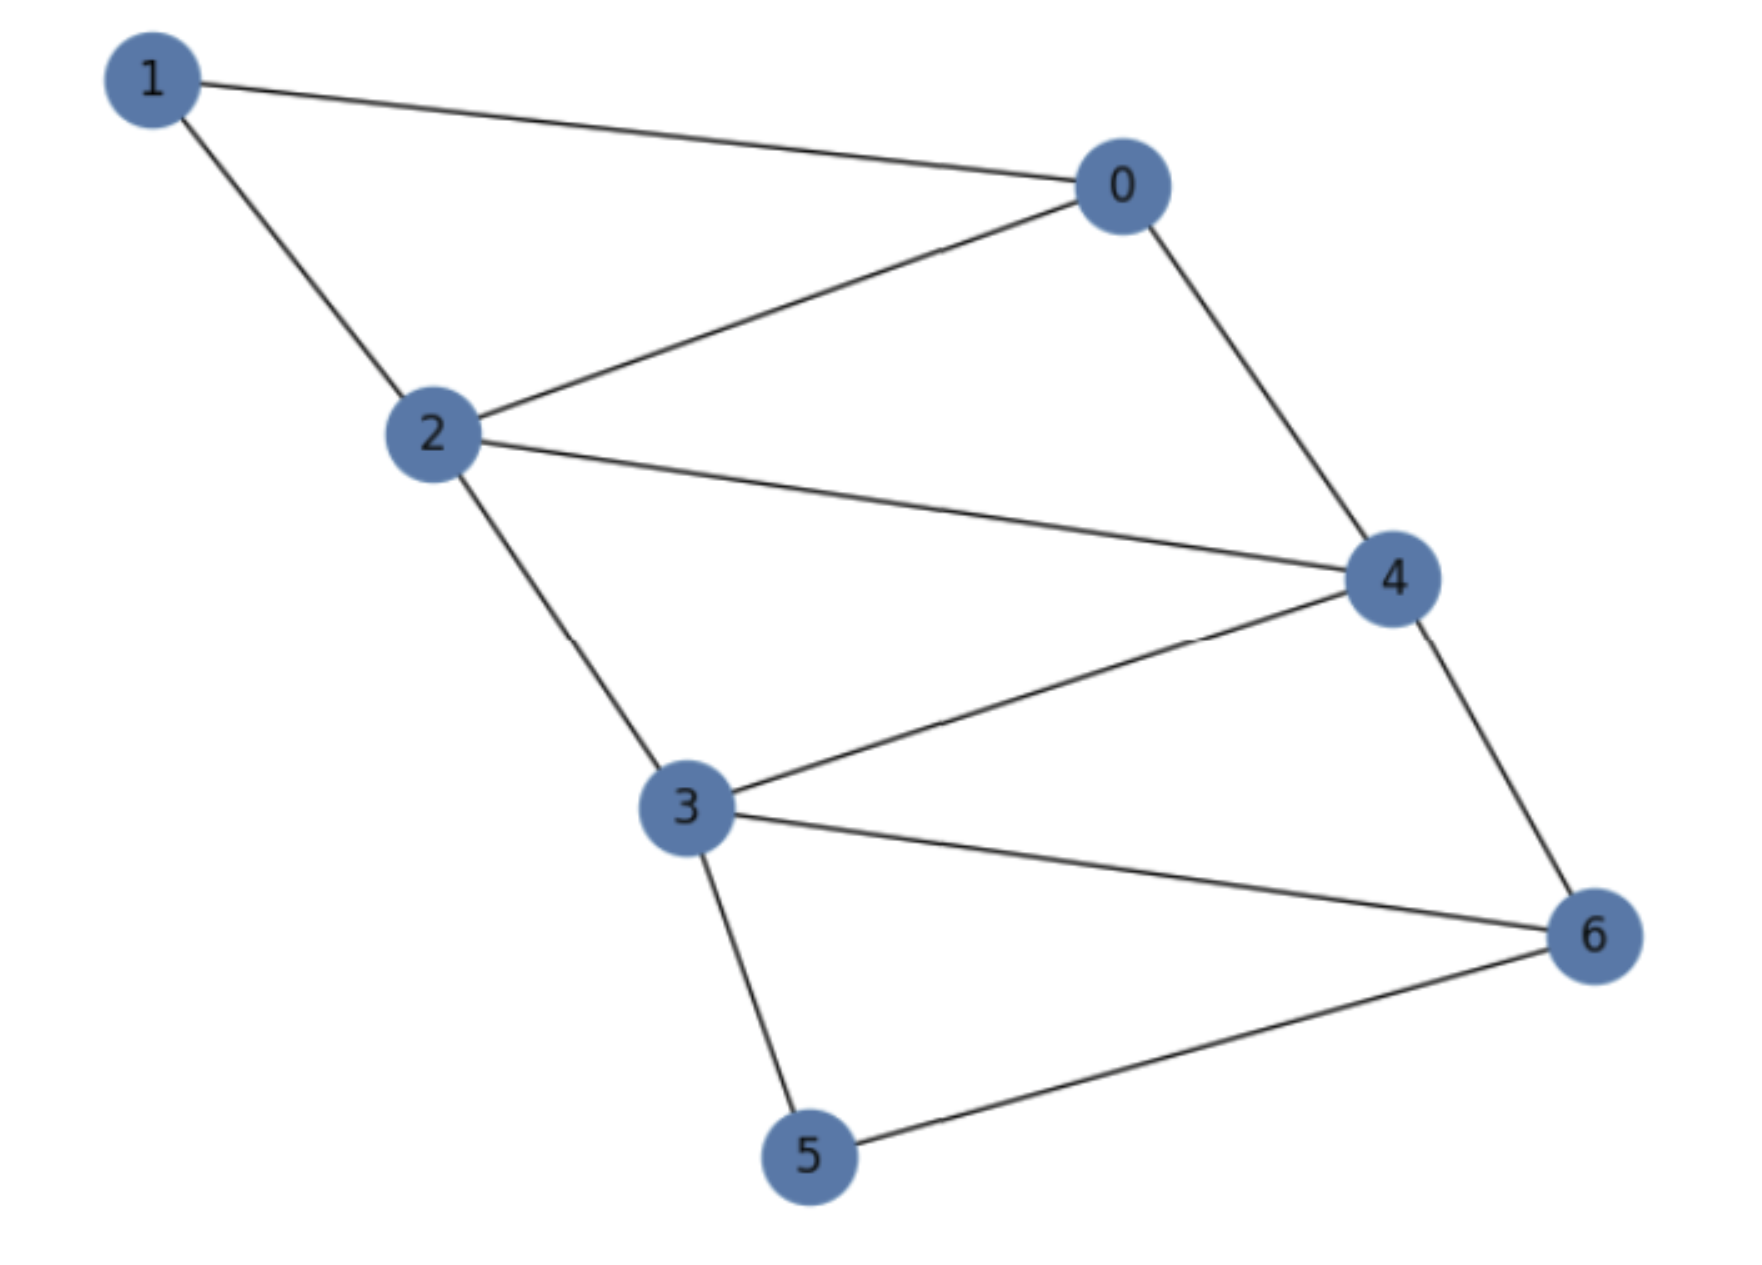

In [40]:
answer_task_4 = """The observables are: 
[
"IIIIIZZ", # 0 -> 1
"IIIIZIZ", # 0 -> 2
"IIZIIIZ", # 0 -> 4
"IIIIZZI", # 1 -> 2
"IIIZZII", # 2 -> 3
"IIZIZII", # 2 -> 4
"IIZZIII", # 3 -> 4
"IZIZIII", # 3 -> 5
"ZIIZIII", # 3 -> 6
"ZIZIIII", # 4 -> 6
"ZZIIIII", # 5 -> 6
]"""

#### Hamiltonian → quantum circuit


We can now create a QAOA Ansatz directly from the above hamiltonian using the qiskit circuit library: 

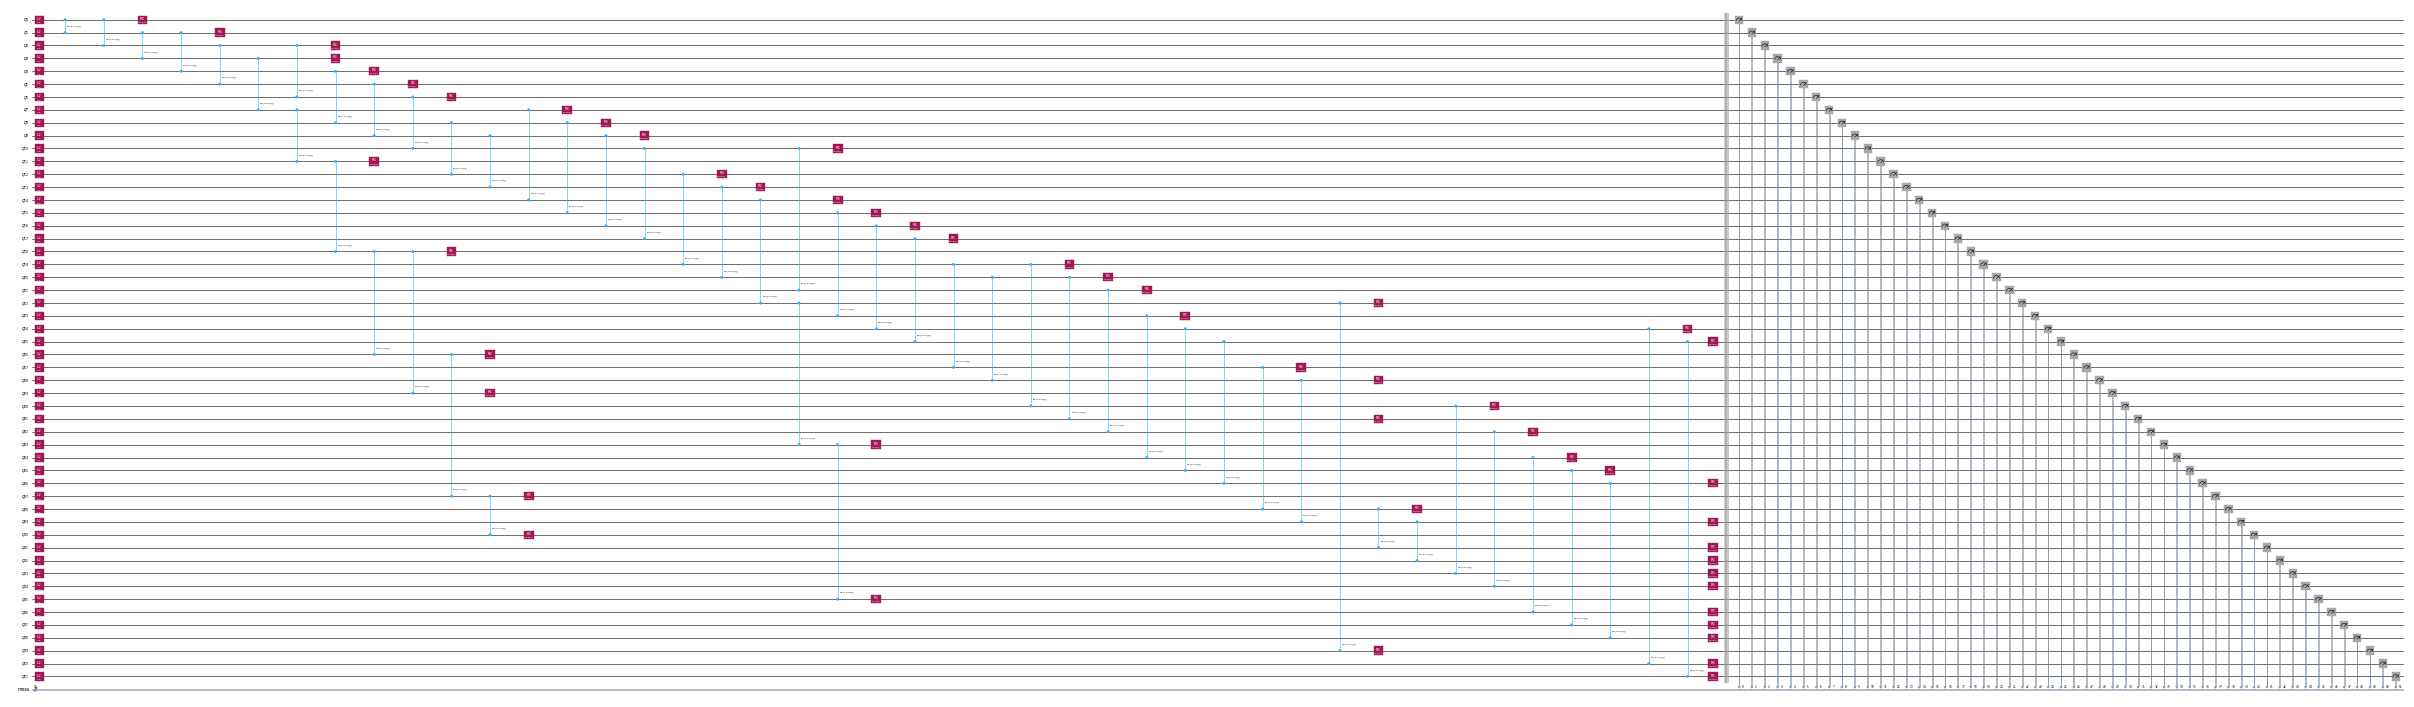

In [42]:
from qiskit.circuit.library import QAOAAnsatz

circuit_max_cut = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit_max_cut.measure_all()
# Decompose to make it a bit more clear what happens.
circuit_max_cut.decompose(reps=2).draw('mpl', fold=False, scale=0.2, idle_wires=False)

### Step 2. Optimize problem for quantum execution

We have now the basic circuit, but we need to transpile it for a specific backend and, if possible, also want to optimize it (reducing the depth and number of gates used). 




C:\Users\dosqas\AppData\Local\Temp\ipykernel_19452\1937928492.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel='ibm_quantum')


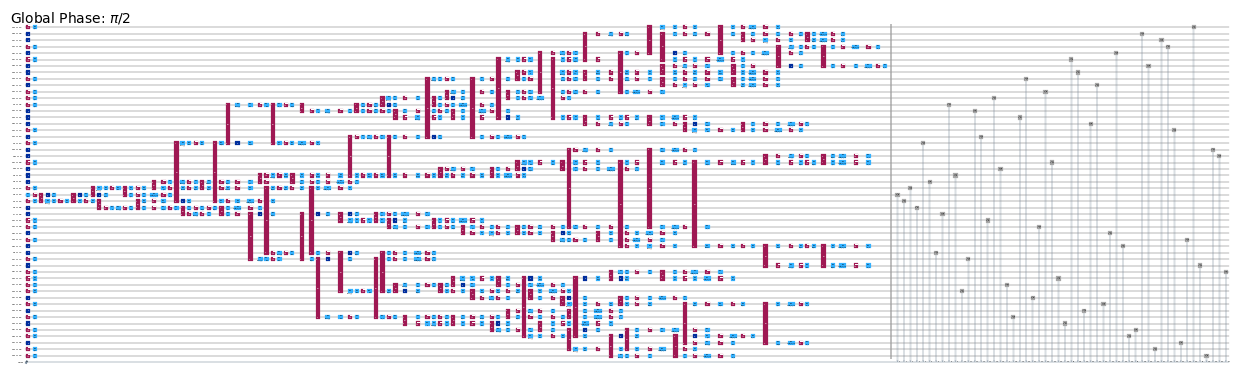

In [48]:
service = QiskitRuntimeService(channel='ibm_quantum')

chosen_backend = service.least_busy(min_num_qubits=127)

# How the virtual qubits are mapped to the physical ones for the given GHZ circuit.
chosen_layout = premade_layout

pm = generate_preset_pass_manager(initial_layout=chosen_layout,
                                    optimization_level=3,
                                    backend=chosen_backend)

candidate_circuit_max_cut = pm.run(circuit_max_cut)
candidate_circuit_max_cut.draw('mpl', fold=False, scale=0.1, idle_wires=False)

In [50]:
print(chosen_backend)

<IBMBackend('ibm_strasbourg')>


<a id="step5"></a>
<div class="alert alert-block alert-success">

**Task 5: Optimize your circuit** Add the missing code above. Choose a suitable backend, and set parameters to make sure you get an optimized result.

> Hint: if you have problems with the layout look at the information about the GHZ state you have above.

</div> 


### Step 3. Execute using Qiskit primitives

To run QAOA, you must know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. 

Optimize these parameters by running an optimization loop on the device. The cell submits jobs until the cost function value has converged and the optimal parameters for $\gamma_k$ and $\beta_k$ are determined.


Depending on the method and start parameters it not always coverges equally fast. Ideally you want to have a fast conversion to be more efficient.

If you have time (and enough ressources on the real devices) you can try to test below with different parameters.


**Estimated Time on device: 18 Minutes:**


#### Find candidate solution by running the optimization on the device


First, run the optimization loop for finding the circuit parameters on a device. 

Choose a suitable optimization method and starting parameters below.  

Use this reference for choosing the minimization method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html


<div class="alert alert-block alert-danger">

**Session is a blocking operation!:** This means is that for the code below you need to let your computer running and you cant let other code of this jupyter notebook run for that time. 

</div>

In [52]:
def cost_function(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [56]:
# Add your code below

classical_optimizer = "COBYLA"
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"


    result = minimize(
        cost_function, #same
        init_params, #same
        args = (candidate_circuit_max_cut, cost_hamiltonian, estimator),
        method = classical_optimizer, # Add optimization method 
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.974196447770222
       x: [ 2.720e+00  3.491e+00]
    nfev: 36
   maxcv: 0.0


<a id="step5"></a>
<div class="alert alert-block alert-success">

**Task 6: Choose optimization parameters** Add the missing code above. Choose a suitable method and parameters.

> How fast does it converge? Check with the plot below.   

</div> 


### Step 4. Post-process, return result in classical format


Here we can check that the cost minimized in the optimization loop has converged to a certain value. 

The code below uses the parameters corresponding to the minimum value of the cost.


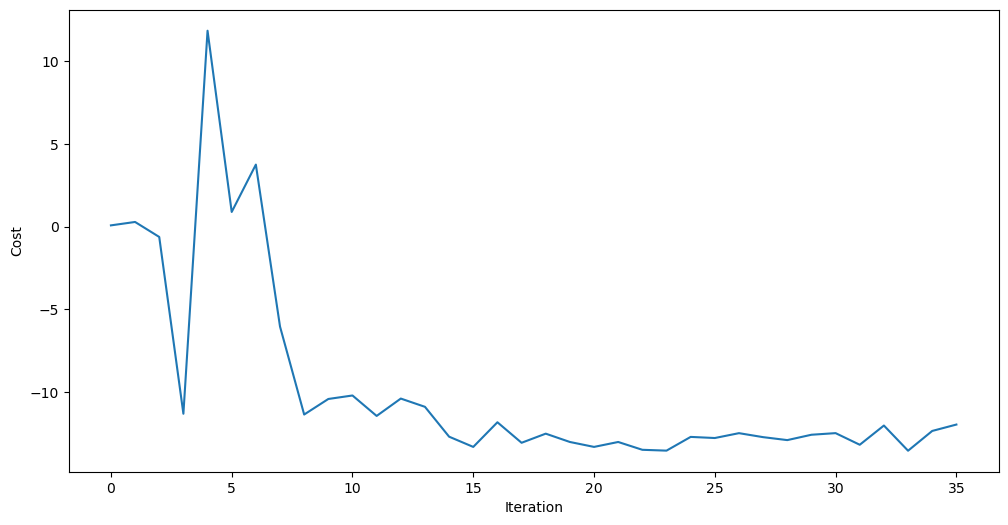

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

### Creating the actual cut.

We now got the optimal parameters for the circuit, but this is not the end result which we look for. 

What we want is the cut, so we can now use the found parameters to construct the exact circuit which we can use to calculate the result.. 

Once the optimal parameters from running QAOA on the device have been found, assign the parameters to the circuit


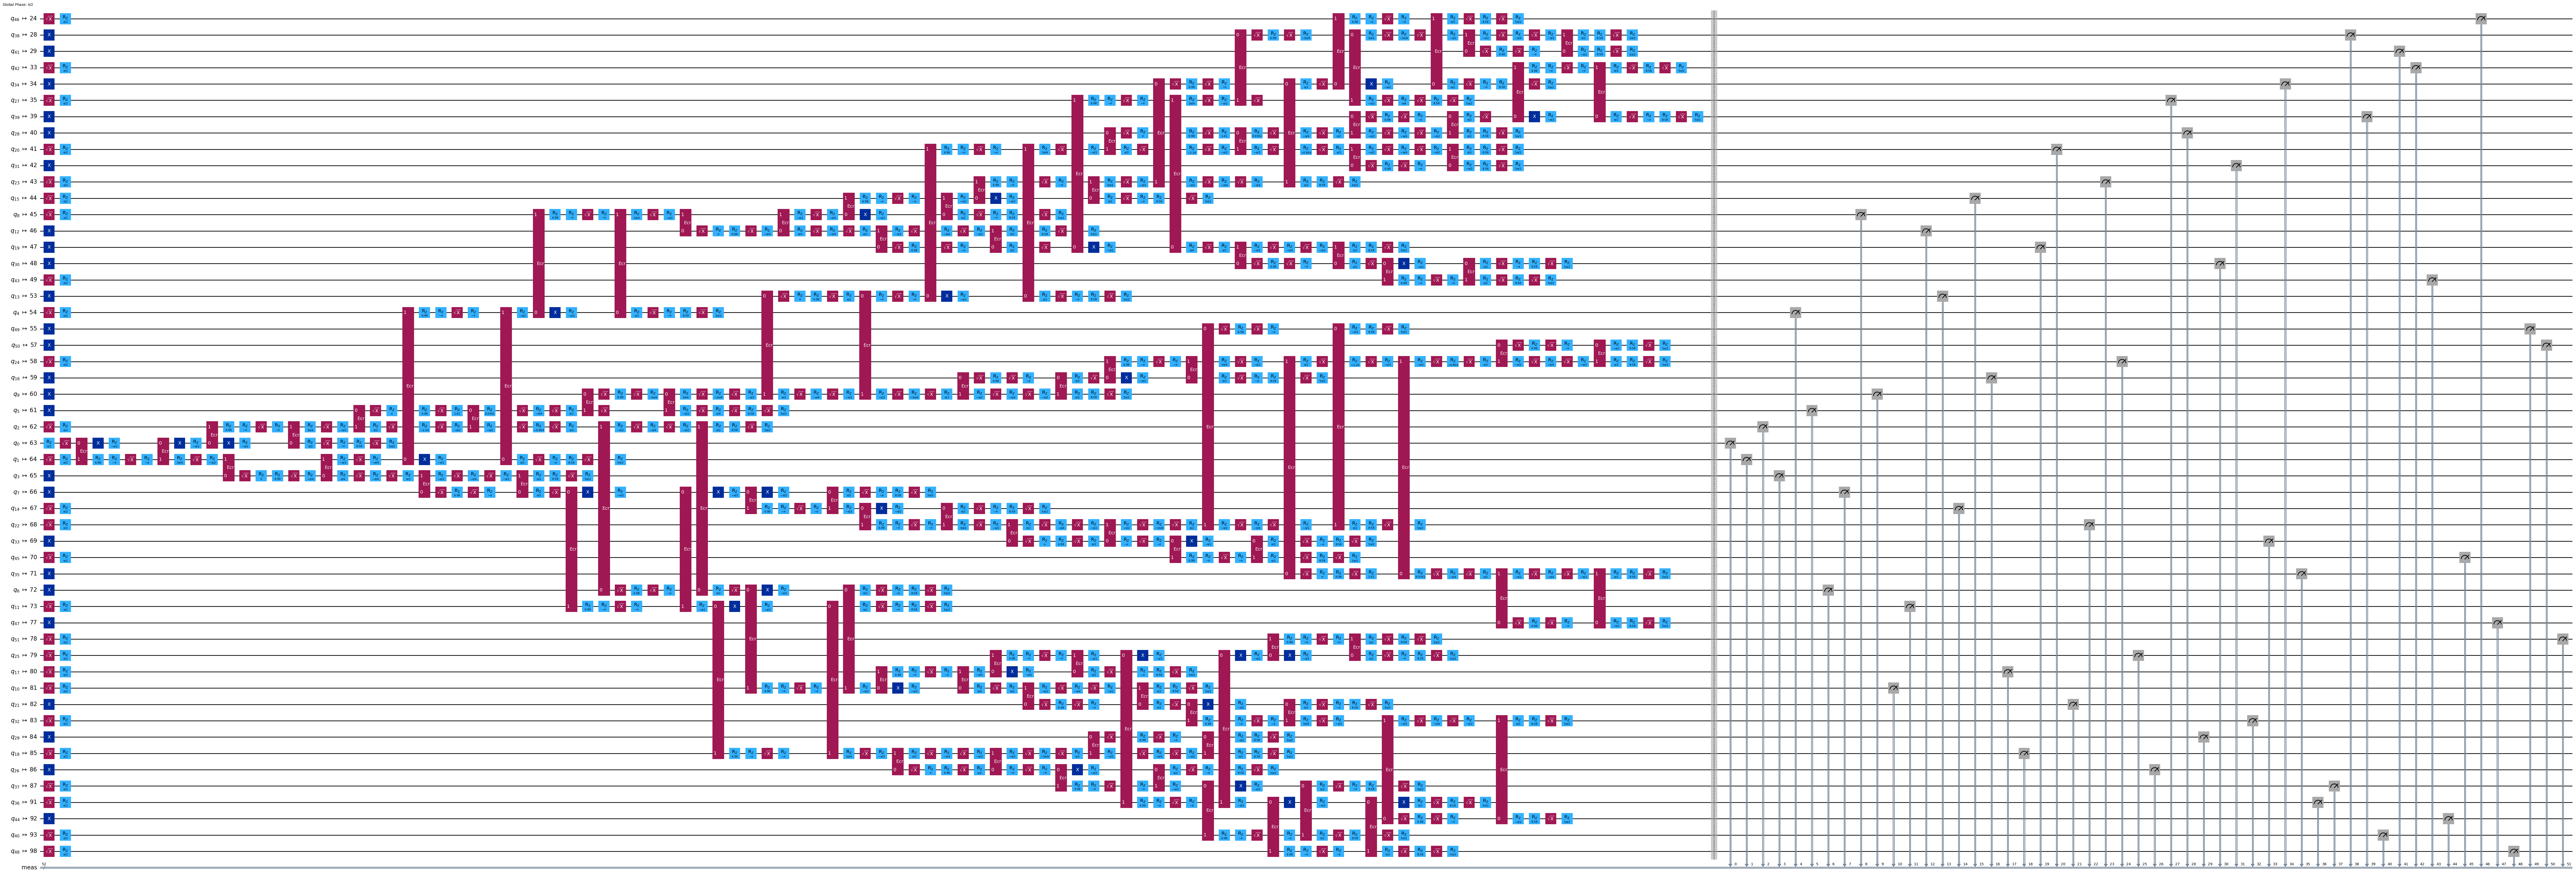

In [60]:
optimized_circuit_max_cut = candidate_circuit_max_cut.assign_parameters(result.x)
optimized_circuit_max_cut.draw('mpl', fold=False, idle_wires=False)

Finally, execute the circuit with the optimal parameters to sample from the corresponding distribution.


Sampling here means that we use the circuit several times each one gives us a solution.
However, because of noise on the device, we can have some variance in the output. 

Therefore we sample several times in order to find a good/the best solution. 

Going through all the samples, i.e. possible solutions (which are near to the actual one) is a lot faster than trying just brute force all possibilities.

We use 10^4 samples here, all possibilities would be 2^50 which is roughly 10^15 which is a way bigger search space.

In [63]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`

# set shots for everything

sampler = Sampler(mode=chosen_backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_max_cut, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
shots = sum(counts_int.values())
final_distribution = {key: val/shots for key, val in counts_int.items()}

print(len(counts_int))

#Change using only keys from counts.items 

10000


Given that the likelihood of each solution is low, extract the solution that corresponds to the lowest cost.


<a id="step5"></a>
<div class="alert alert-block alert-success">

**Task 7: Find the best solution** We have now many samples, which all represent potential solutions. Find the best solution.

> When you found your solution, visualize it with the function below (after visualization).
>
> Hint: If you dont know what to do, you can find one potential way here: https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm but try it yourself first:
>
> Think about what makes the best solution? And how can we extract it with the samples.
> 

</div> 


In [90]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

## Auxiliary function helping to calculate the cost for a given state (sample output)
## You dont need to understand this in detail.
def calculate_cost(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced]).real


# Add the missing code to finish this function.
def best_solution(samples, hamiltonian):
    """Find solution (bitstring) with lowest cost"""
    min_cost = float("inf")
    best_sample = None

    for sample in samples.keys():
        cost = calculate_cost(sample, hamiltonian)
        if cost < min_cost:
            min_cost = cost
            best_sample = sample

    return best_sample

best_solution = best_solution(final_distribution, cost_hamiltonian)
best_solution_string = to_bitstring(int(best_solution), len(prepared_graph))
best_solution_string.reverse()

print("Result bitstring:", best_solution_string)

Result bitstring: [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


### Visualization

We want to visualize the cut. Nodes of the same color belong to the same group.


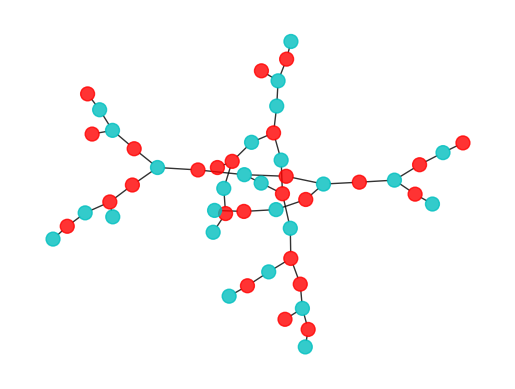

In [98]:
# auxiliary function to plot graphs
def plot_result(G, x):
    #colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    colors = ["r" if x[i] == 0 else "c" for i in range(n)]

    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(prepared_graph, best_solution_string)

And then calculate the the value of the cut. What should the ideal value be? Think about the start of the exercise. 


In [100]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))

cut_value= evaluate_sample(best_solution_string, prepared_graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 45


The theoretical best value should be == the nr of edges, in this case 51